In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
import scipy.sparse as sp
from MulticoreTSNE import MulticoreTSNE as TSNE
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
wdir = "/Users/jakobmaeots/Internship/"
os.chdir( wdir )

loom_file = "Data/Velmeshev/Velmeshev_2019_matrix.loom"

# Open the loom file with loompy
ds = lp.connect(loom_file)

# # path to loom file with basic filtering applied (this will be created in the "initial filtering" step below). Optional.
f_loom_path_scenic = "Data/Velmeshev/Velmeshev_1CTRL.loom"

# path to anndata object, which will be updated to store Scanpy results as they are generated below
f_anndata_path = "Data/Velmeshev/Velmeshev_1CTRL.h5ad"

# path to pyscenic output
f_pyscenic_output = "Data/Velmeshev/Velmeshev_1CTRL_SCENIC.loom"

# loom output, generated from a combination of Scanpy and pySCENIC results:
f_final_loom = 'Data/Velmeshev/Velmeshev_1CTRL_integrated-output.loom'

In [3]:
X = ds[:, :]

# Function to process attributes: try to squeeze to 1D; if not, skip the attribute
def process_attributes(attr_dict):
    new_attrs = {}
    for key in attr_dict.keys():
        try:
            arr = np.array(attr_dict[key])
            arr = np.squeeze(arr)
            if arr.ndim == 1:
                new_attrs[key] = arr
            else:
                print(f"Skipping attribute {key}: array is not 1D after squeezing (shape {arr.shape})")
        except Exception as e:
            print(f"Error processing attribute {key}: {e}")
    return new_attrs

In [4]:
# Process cell attributes (obs) and gene attributes (var)
obs_dict = process_attributes(ds.ca)
var_dict = process_attributes(ds.ra)

# Create DataFrames
obs = pd.DataFrame(obs_dict)
var = pd.DataFrame(var_dict)

# (Optional) If you expect specific keys (like "CellID" or "Gene") use them for index names.
# If these keys are missing or problematic, you can create simple indices.
if "CellID" in ds.ca.keys():
    obs.index = np.array(ds.ca["CellID"]).squeeze()
else:
    obs.index = [f"cell_{i}" for i in range(obs.shape[0])]

if "Gene" in ds.ra.keys():
    var.index = np.array(ds.ra["Gene"]).squeeze()
else:
    var.index = [f"gene_{i}" for i in range(var.shape[0])]

# Loom files are typically genes x cells.
# Scanpy’s AnnData expects the data matrix to be cells x genes.
# Also, if your matrix is large and sparse (which is common), convert it.
if not sp.issparse(X):
    print("Converting expression matrix to sparse CSR format")
    X = sp.csr_matrix(X)

Converting expression matrix to sparse CSR format


In [5]:
adata = sc.AnnData(X=X.T, obs=obs, var=var)
adata.var_names_make_unique()
# Close the loom file connection
ds.close()

# Verify the resulting AnnData object
print(adata)

AnnData object with n_obs × n_vars = 104559 × 65217
    obs: 'CT_ann_ABM_MCA_scmap_cell2cluster_51_CTs', 'CT_ann_score_ABM_MCA_scmap_cell2cluster_51_CTs', 'Capbatch', 'RNA Integrity Number', 'RNA mitochondr. percent', 'RNA ribosomal percent', 'Seqbatch', 'UMIs', 'age', 'batch', 'brain_region', 'cell', 'cell_id', 'cluster', 'condition', 'donor_id', 'genes', 'obs_names', 'post_mortem_interval', 'region', 'sample', 'sex', 'study_id'
    var: 'Gene', 'ensembl_id', 'gene_name', 'var_names'


/opt/anaconda3/envs/scenic_env_py310/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/scenic_env_py310/lib/python3.10/site-packages/anndata/utils.py:268: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


In [6]:
unique_clusters = adata.obs['cluster'].unique()

# Print the unique study IDs
print("Unique clusters:", unique_clusters)

Unique clusters: ['Neu-NRGN-II' 'L5/6' 'Oligodendrocytes' 'OPC' 'AST-FB' 'Endothelial'
 'Microglia' 'Neu-NRGN-I' 'IN-VIP' 'L5/6-CC' 'IN-SV2C' 'L2/3' 'IN-PV' 'L4'
 'IN-SST' 'Neu-mat' 'AST-PP']


In [7]:
unique_donor_ids = adata.obs['donor_id'].unique()

# Print the unique study IDs
print("Donor study IDs:", unique_donor_ids)

Donor study IDs: ['Velmeshev_2019_1823' 'Velmeshev_2019_4341' 'Velmeshev_2019_4849'
 'Velmeshev_2019_4899' 'Velmeshev_2019_5144' 'Velmeshev_2019_5163'
 'Velmeshev_2019_5242' 'Velmeshev_2019_5278' 'Velmeshev_2019_5294'
 'Velmeshev_2019_5387' 'Velmeshev_2019_5391' 'Velmeshev_2019_5403'
 'Velmeshev_2019_5408' 'Velmeshev_2019_5419' 'Velmeshev_2019_5531'
 'Velmeshev_2019_5538' 'Velmeshev_2019_5554' 'Velmeshev_2019_5565'
 'Velmeshev_2019_5577' 'Velmeshev_2019_5841' 'Velmeshev_2019_5864'
 'Velmeshev_2019_5879' 'Velmeshev_2019_5893' 'Velmeshev_2019_5936'
 'Velmeshev_2019_5939' 'Velmeshev_2019_5945' 'Velmeshev_2019_5958'
 'Velmeshev_2019_5976' 'Velmeshev_2019_5978' 'Velmeshev_2019_6032'
 'Velmeshev_2019_6033']


In [8]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(dpi=150, fontsize=10, dpi_save=600)

/var/folders/3n/bg3b1qfs4jz9hnh_q29xp5k00000gn/T/ipykernel_42867/1167869884.py:2: FutureWarning: Use `print_header` instead
  sc.logging.print_versions()


In [9]:
# Set maximum number of jobs for Scanpy.
sc.settings.njobs = 20

In [10]:
nCountsPerGene = np.sum(adata.X, axis=0)
nCellsPerGene = np.sum(adata.X>0, axis=0)

# Show info
print("Number of counts (in the dataset units) per gene:", nCountsPerGene.min(), " - " ,nCountsPerGene.max())
print("Number of cells in which each gene is detected:", nCellsPerGene.min(), " - " ,nCellsPerGene.max())

Number of counts (in the dataset units) per gene: 0.0  -  32212542.0
Number of cells in which each gene is detected: 0  -  104067


In [11]:
nCells=adata.X.shape[0]

# pySCENIC thresholds
minCountsPerGene=3*.01*nCells # 3 counts in 1% of cells
print("minCountsPerGene: ", minCountsPerGene)

minSamples=.01*nCells # 1% of cells
print("minSamples: ", minSamples)

minCountsPerGene:  3136.77
minSamples:  1045.59


In [12]:
# Define the patient IDs and cell type you want to keep
control_id = "Velmeshev_2019_5577"

# Filter the dataset to include only cells from these two patient IDs and the specified cell type
adata = adata[(adata.obs['donor_id'].isin([ control_id]))]

# Verify the filtering
print(f"Number of cells after filtering: {adata.n_obs}")
print(f"Unique study IDs after filtering: {adata.obs['donor_id'].unique()}")

Number of cells after filtering: 4131
Unique study IDs after filtering: ['Velmeshev_2019_5577']


In [13]:
# Simply compute the number of genes per cell
sc.pp.filter_cells(adata, min_genes=0)

# Identify mitochondrial genes, assuming gene names starting with 'MT-'
mito_genes = adata.var_names.str.startswith('MT-')

# Compute the sum of counts in mitochondrial genes for each cell
mito_sum = np.array(adata[:, mito_genes].X.sum(axis=1)).flatten()

# Compute the total counts per cell
total_sum = np.array(adata.X.sum(axis=1)).flatten()

# Compute percent mitochondrial and add total counts to adata.obs
adata.obs['percent_mito'] = mito_sum / total_sum
adata.obs['n_counts'] = total_sum

/opt/anaconda3/envs/scenic_env_py310/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:170: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


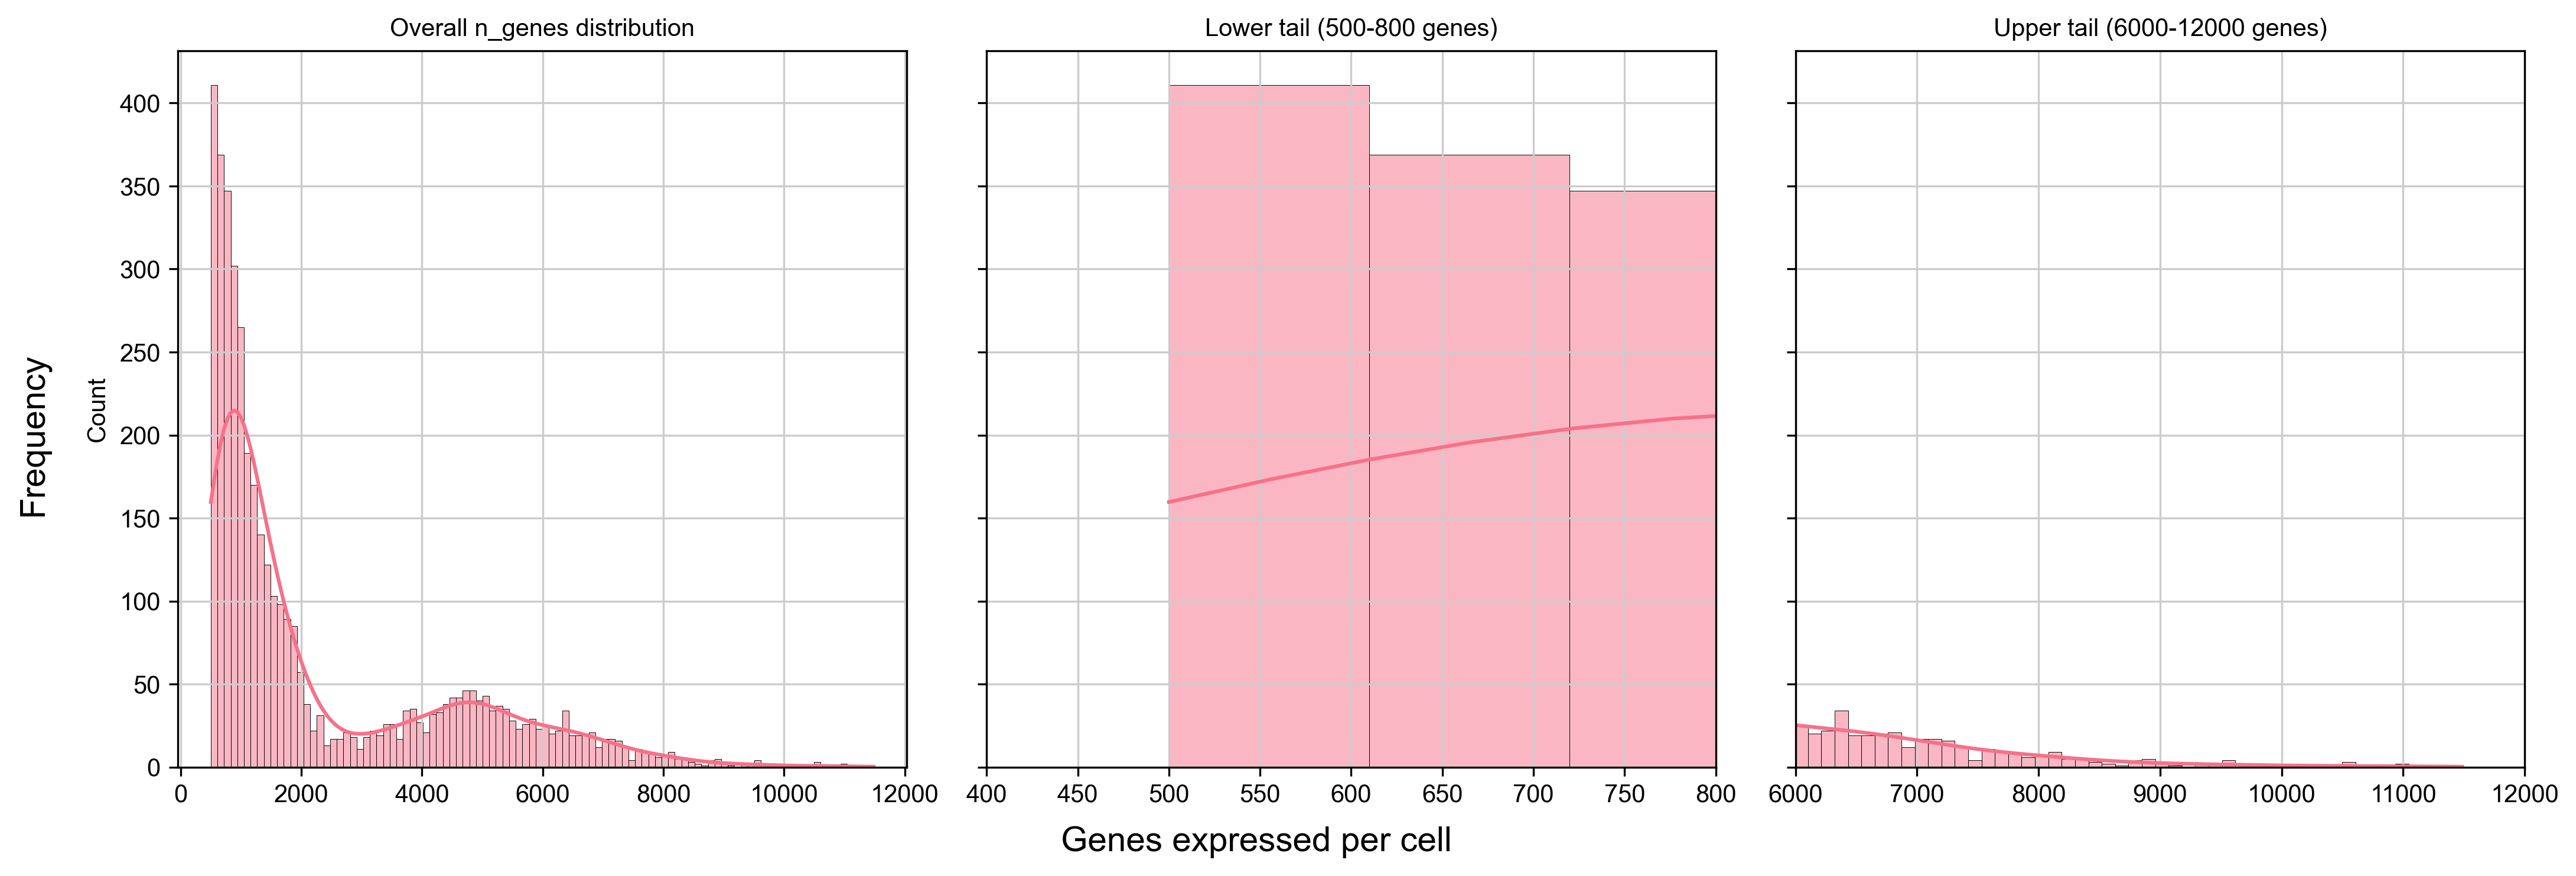

In [14]:
# Set the color palette
sns.set_palette("husl")

# Use the n_genes column from your AnnData object
x = adata.obs['n_genes']

# Define the number of bins for the histogram
nbins = 100

# Create subplots: overall distribution, lower tail, and upper tail
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi=150, sharey=True)

# Overall n_genes distribution
sns.histplot(x, ax=ax1, bins=nbins, kde=True)
ax1.set_title('Overall n_genes distribution')

# Lower tail: limit x-axis from 500 to 800
sns.histplot(x, ax=ax2, bins=nbins, kde=True)
ax2.set_xlim(400, 800)
ax2.set_title('Lower tail (500-800 genes)')

# Upper tail: limit x-axis from 6000 to 12000
sns.histplot(x, ax=ax3, bins=nbins, kde=True)
ax3.set_xlim(6000, 12000)
ax3.set_title('Upper tail (6000-12000 genes)')

# Remove individual x-axis labels (use global x-label instead)
for ax in (ax1, ax2, ax3):
    ax.set_xlabel('')

# Add a common y-axis label for Frequency
fig.text(0.04, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', fontsize=14)

# Add a common x-axis label for Genes expressed per cell
fig.text(0.5, 0.04, 'Genes expressed per cell', ha='center', va='center', fontsize=14)

# Adjust layout to minimize overlap
fig.tight_layout(rect=[0.05, 0.05, 1, 1])

plt.show()

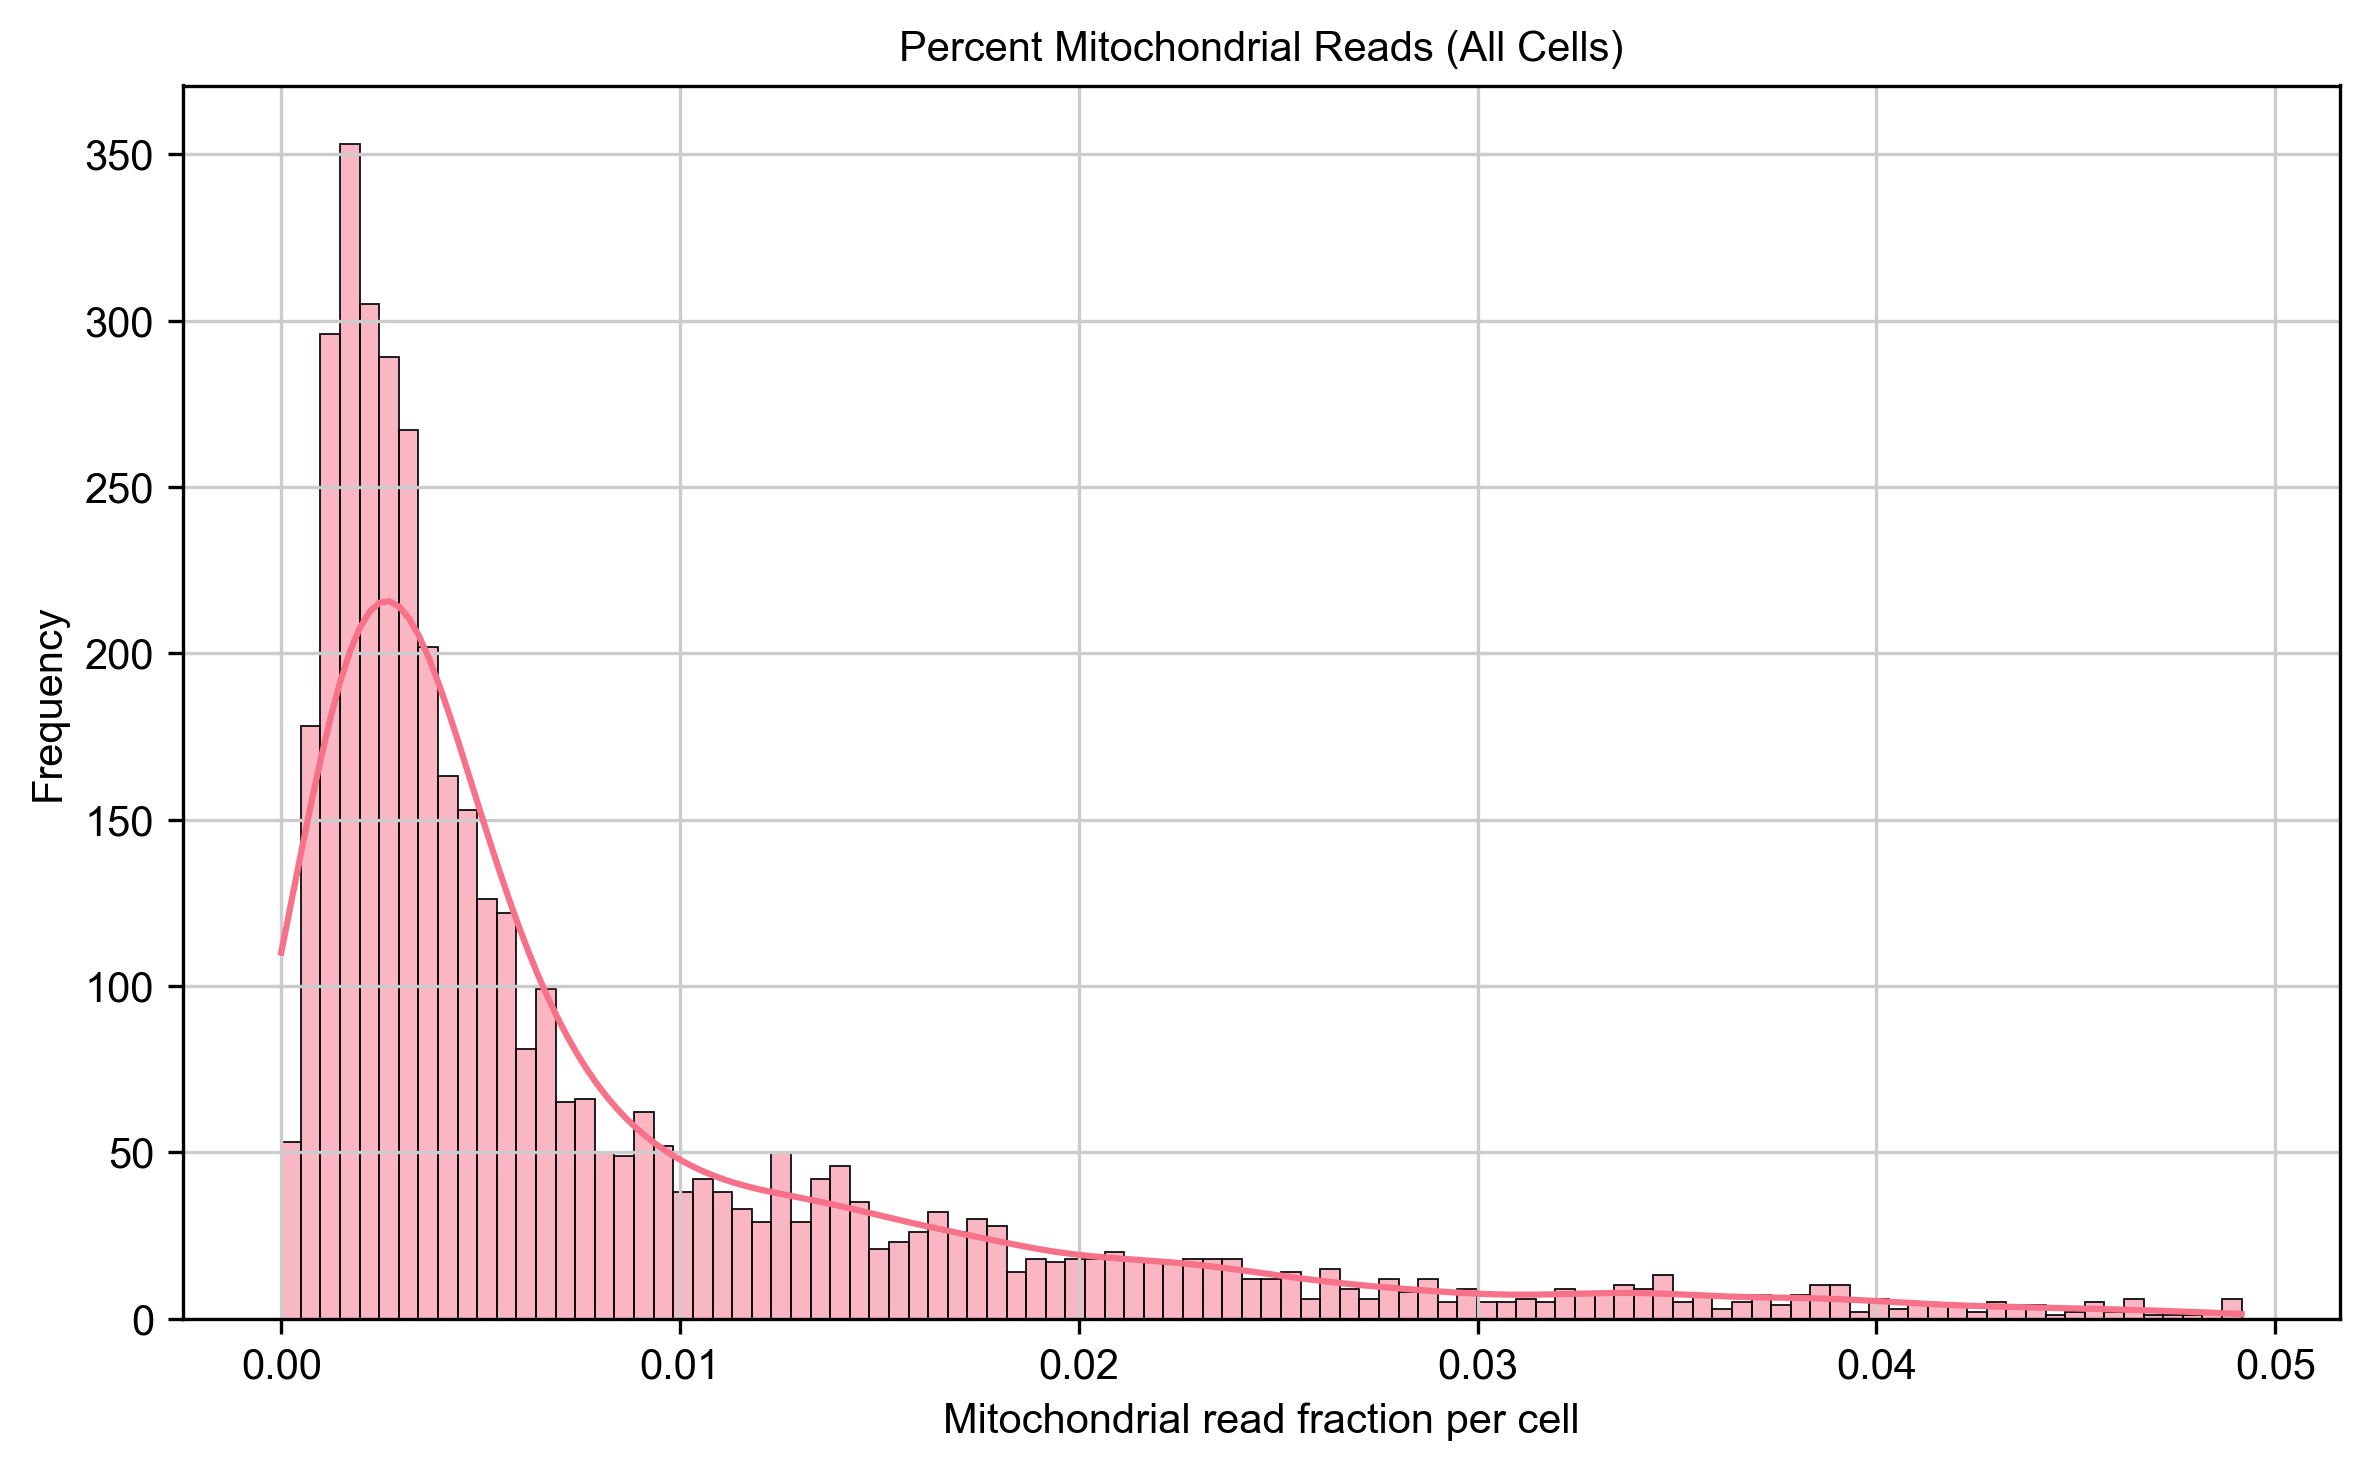

In [15]:
# Set the color palette (optional)
sns.set_palette("husl")

# Extract your data
x = adata.obs['percent_mito']
nbins = 100

# Create a single plot
fig, ax = plt.subplots(figsize=(8, 5), dpi=150)
sns.histplot(x, ax=ax, bins=nbins, kde=True)
ax.set_title("Percent Mitochondrial Reads (All Cells)")
ax.set_xlabel("Mitochondrial read fraction per cell")
ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

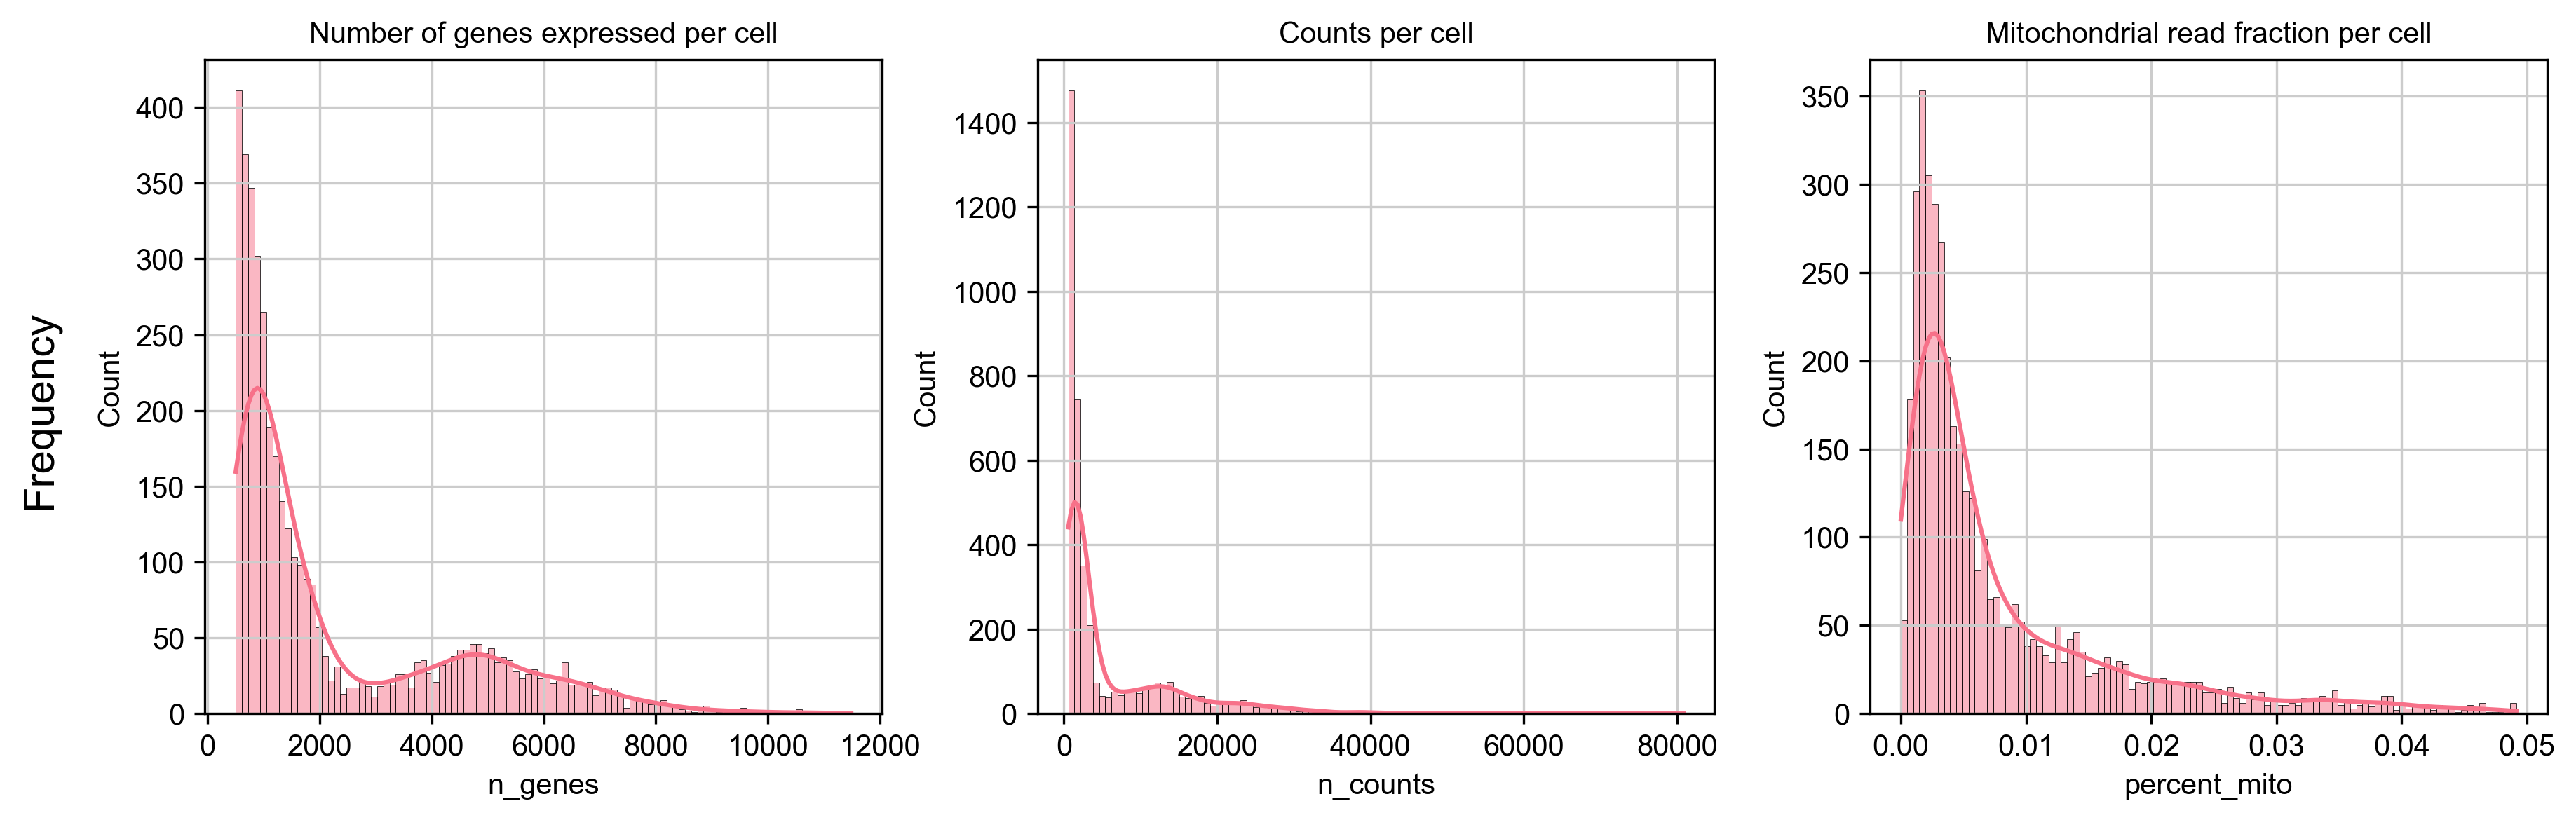

In [16]:
# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)

# Plot histograms with kernel density estimates
sns.histplot(adata.obs['n_genes'], ax=ax1, bins=100, kde=True)
sns.histplot(adata.obs['n_counts'], ax=ax2, bins=100, kde=True)
sns.histplot(adata.obs['percent_mito'], ax=ax3, bins=100, kde=True)

# Set titles
ax1.set_title('Number of genes expressed per cell')
ax2.set_title('Counts per cell')
ax3.set_title('Mitochondrial read fraction per cell')

# Set y-axis label
fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

# Adjust layout
fig.tight_layout()

# Save the figure
fig.savefig('filtering_panel_prefilter_Velmeshev_1CTRL.pdf', dpi=600, bbox_inches='tight')

/opt/anaconda3/envs/scenic_env_py310/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:921: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g: sns.axisgrid.FacetGrid = sns.catplot(


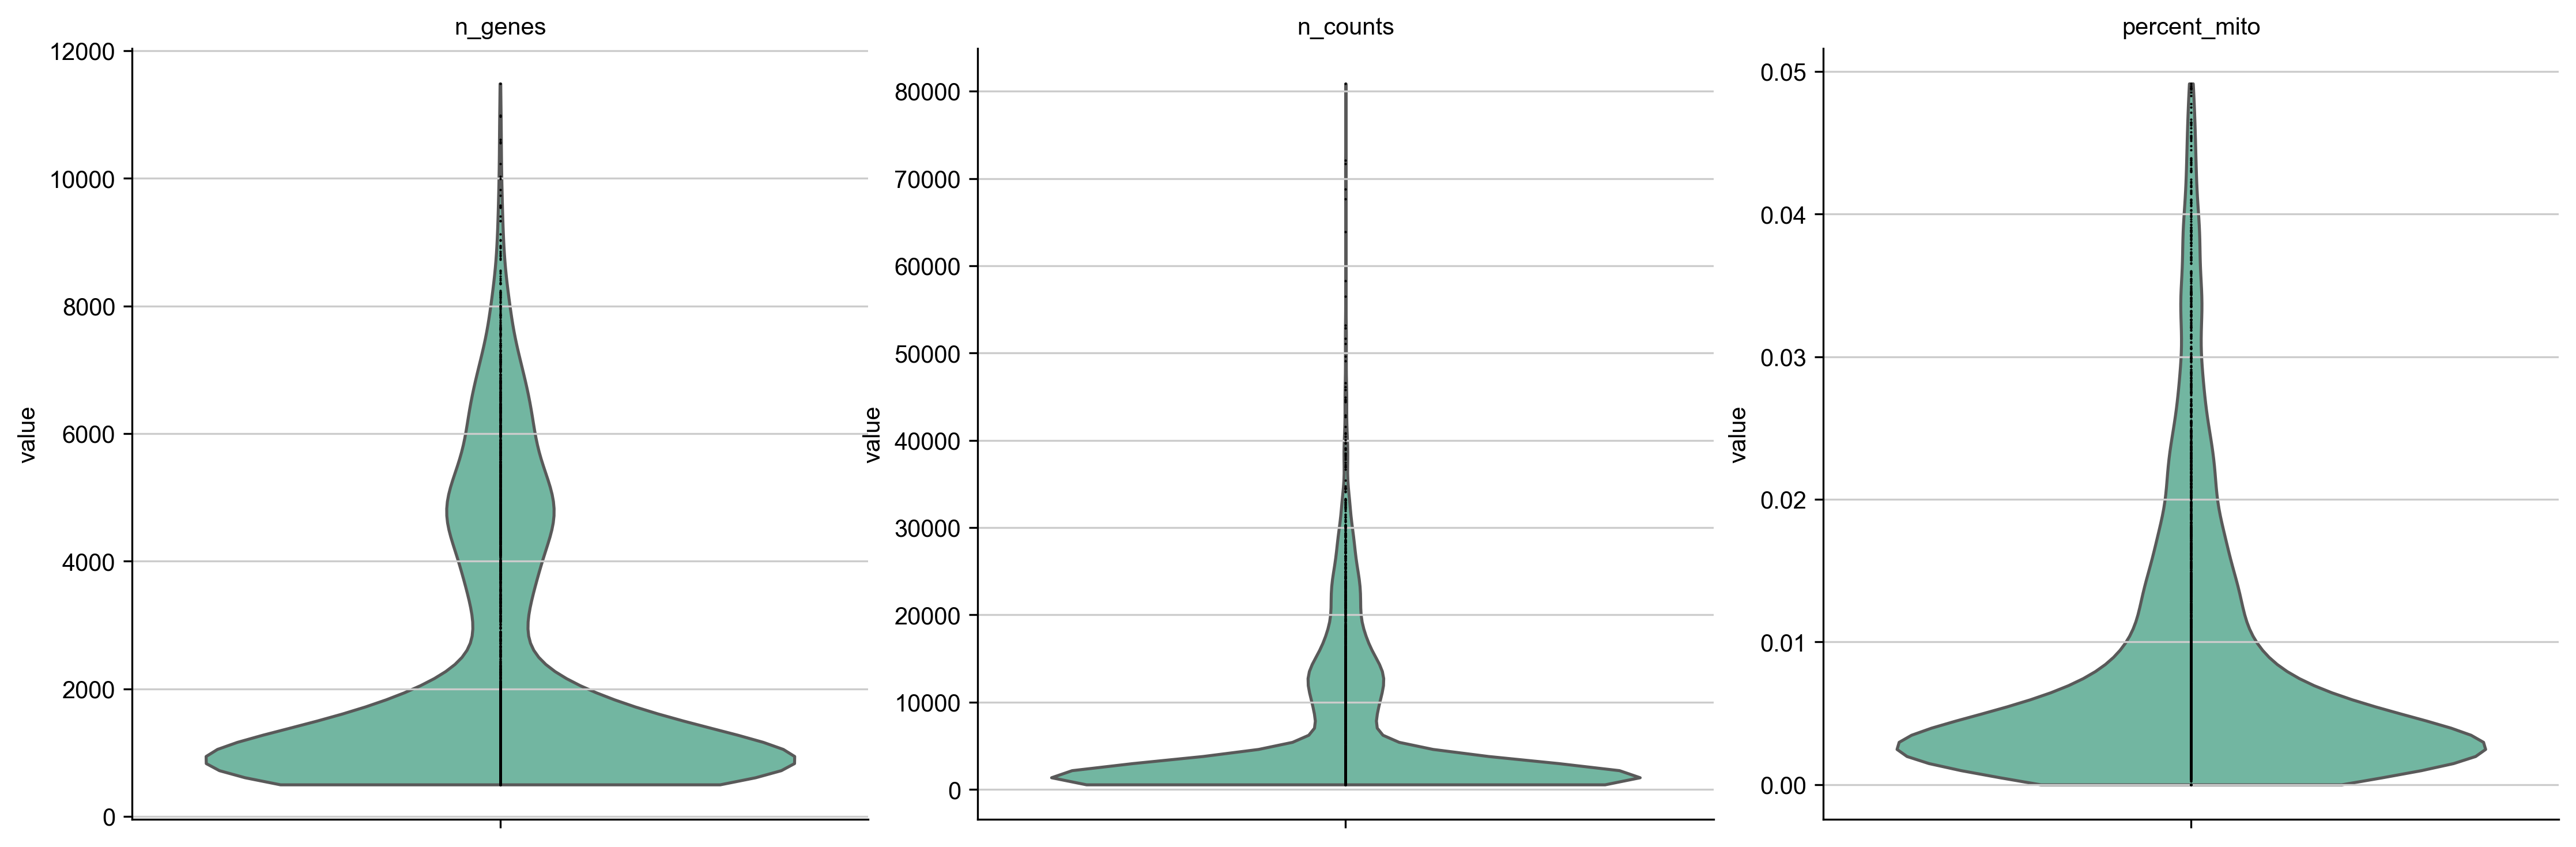

In [17]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
    jitter=0, multi_panel=True, palette="Set2")

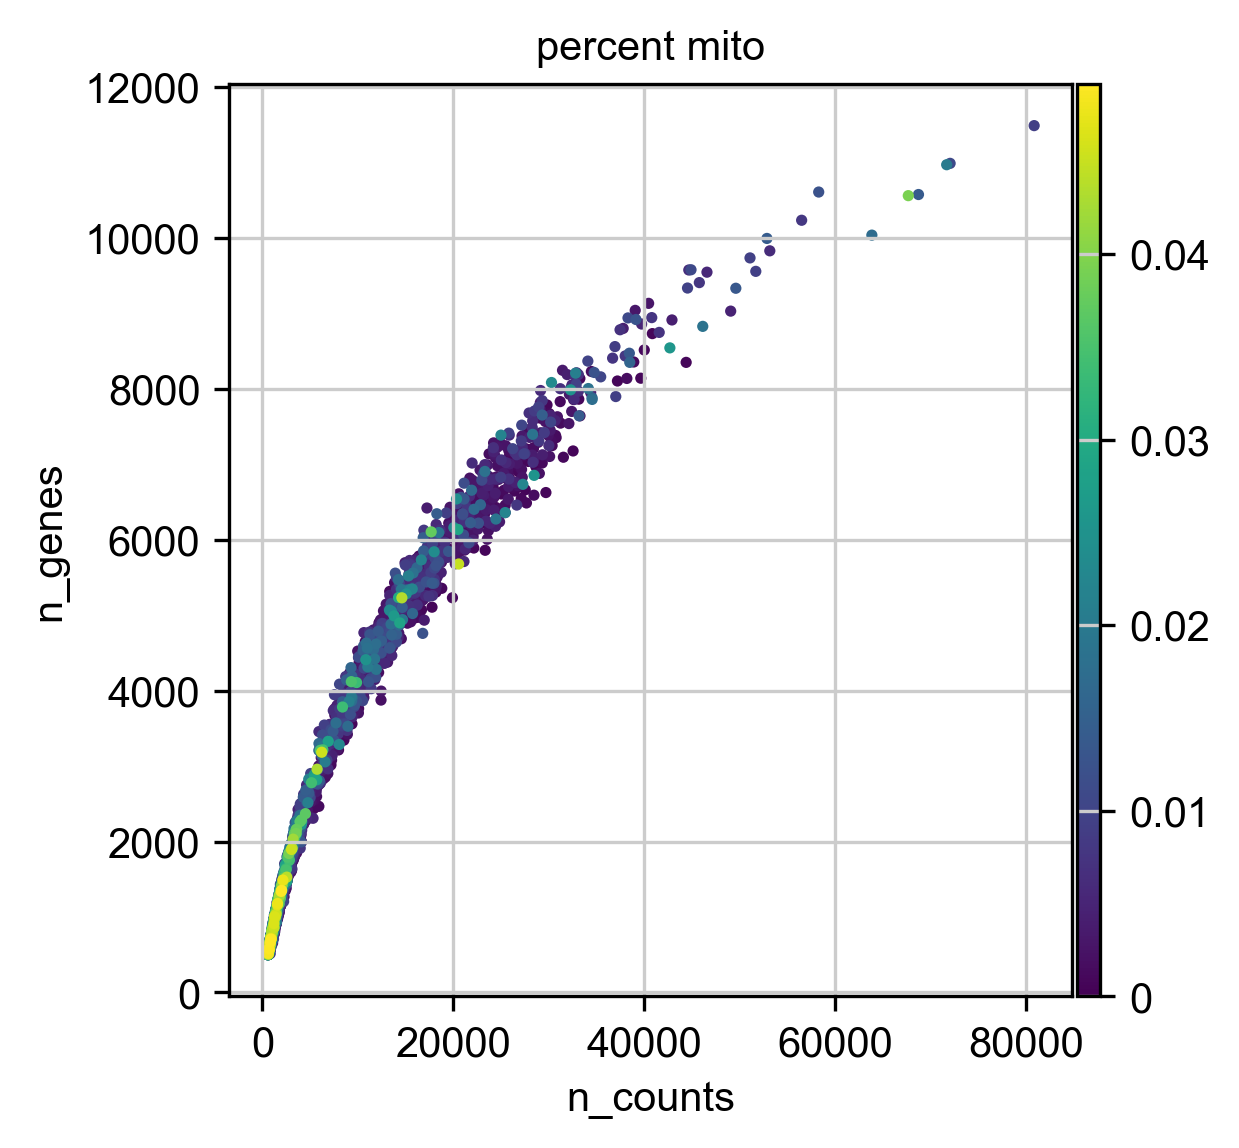

In [18]:
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='percent_mito')

In [19]:
sc.pp.filter_cells(adata, min_genes=500 )
sc.pp.filter_genes(adata, min_cells=3 )

filtered out 36653 genes that are detected in less than 3 cells


In [20]:
adata = adata[adata.obs['n_genes'] < 8000, :]

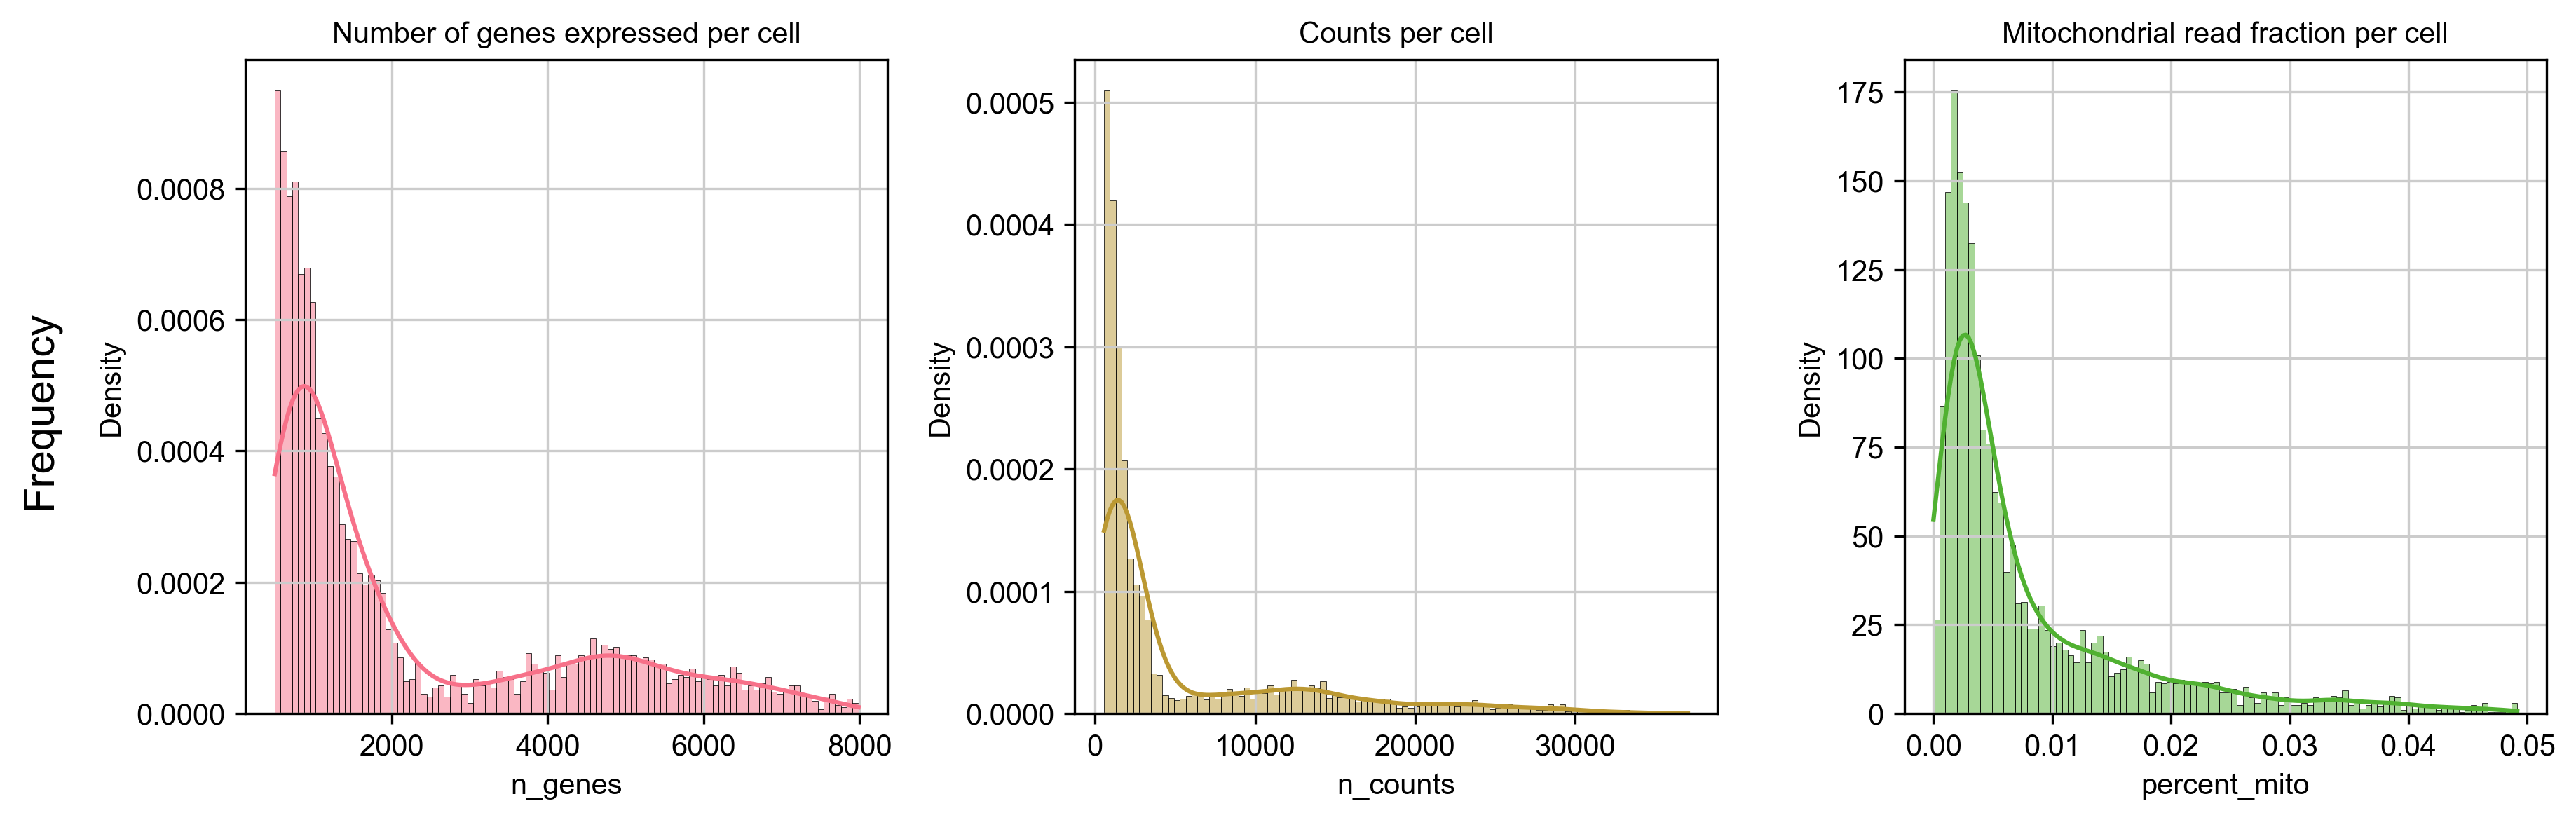

In [21]:
# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)

# Plot histograms with kernel density estimates
sns.histplot(adata.obs['n_genes'], ax=ax1, bins=100, kde=True, color=sns.color_palette("husl")[0], stat="density")
sns.histplot(adata.obs['n_counts'], ax=ax2, bins=100, kde=True, color=sns.color_palette("husl")[1], stat="density")
sns.histplot(adata.obs['percent_mito'], ax=ax3, bins=100, kde=True, color=sns.color_palette("husl")[2], stat="density")

# Set titles
ax1.set_title('Number of genes expressed per cell')
ax2.set_title('Counts per cell')
ax3.set_title('Mitochondrial read fraction per cell')

# Set y-axis label
fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

# Adjust layout
fig.tight_layout()

# Save the figure
fig.savefig('filtering_panel_postfilter_Velmeshev_1CTRL.pdf', dpi=600, bbox_inches='tight')

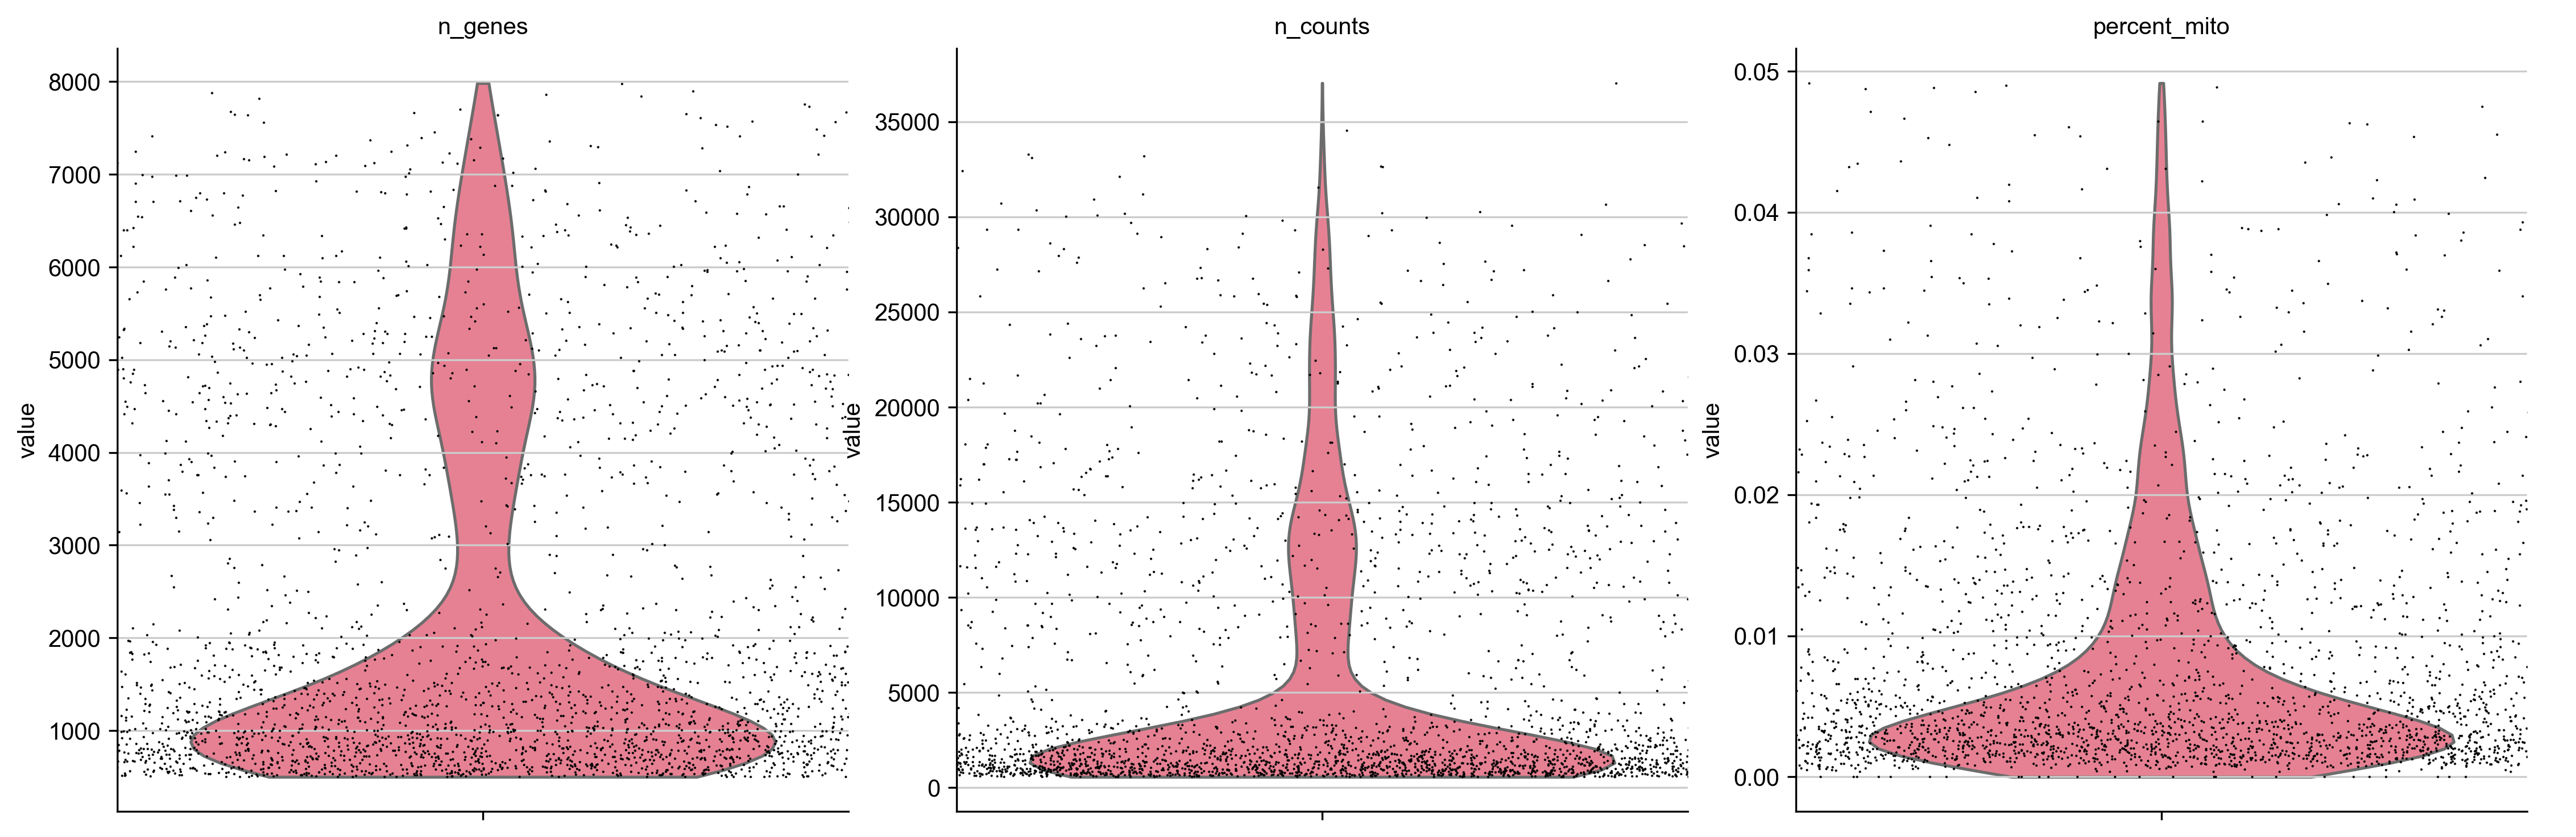

In [22]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
    jitter=0.8, multi_panel=True )

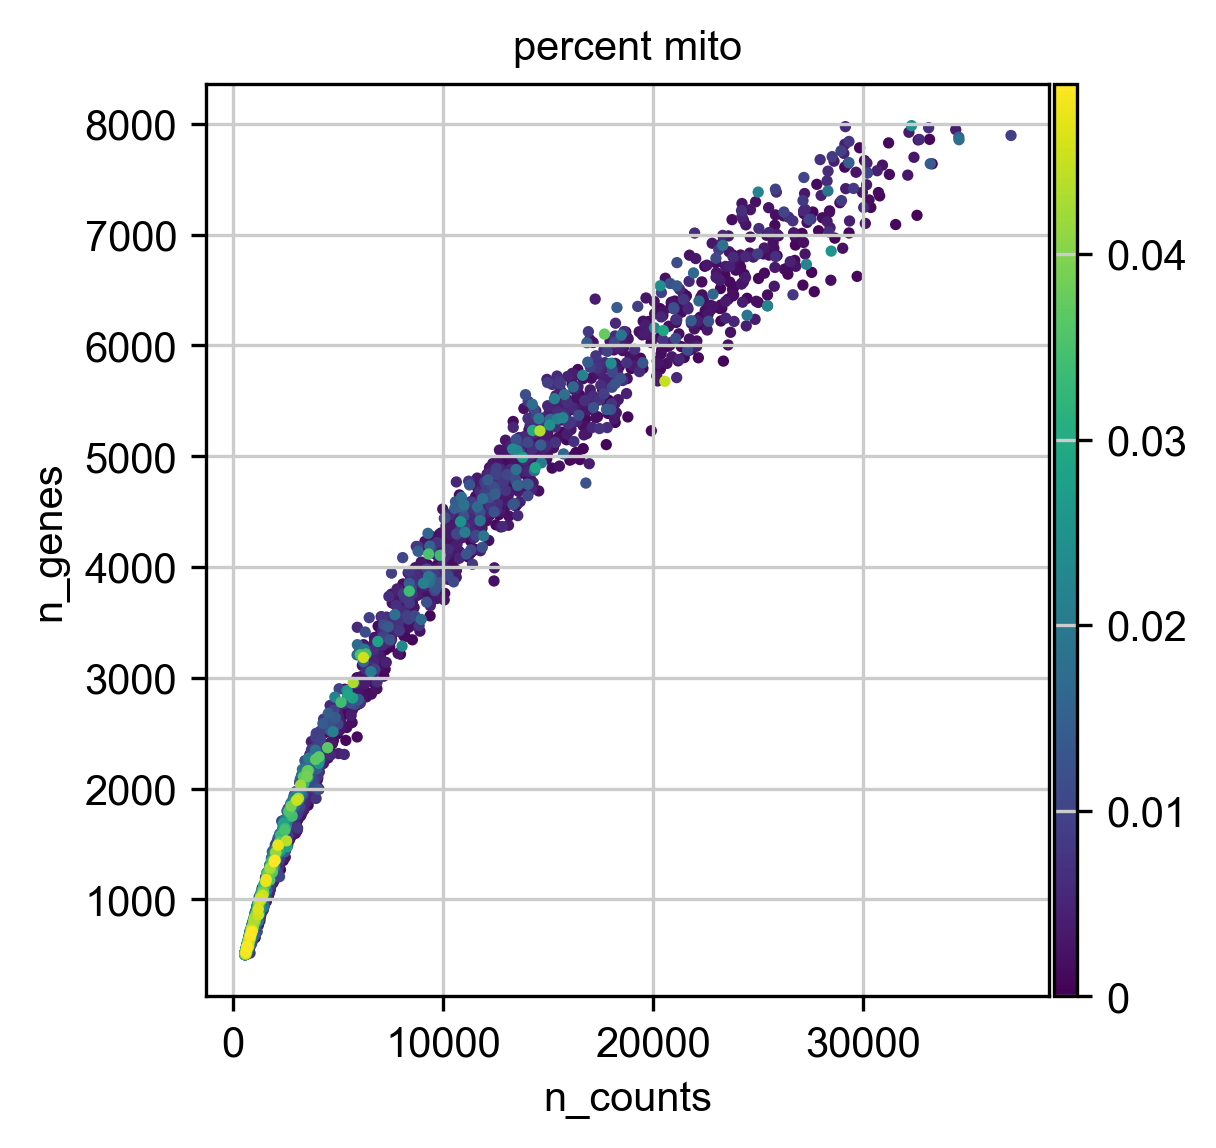

In [23]:
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='percent_mito')

In [24]:
adata.write( f_anndata_path )

In [25]:
# create basic row and column attributes for the loom file:
row_attrs = {
    "Gene": np.array(adata.var_names) ,
}
col_attrs = {
    "CellID": np.array(adata.obs_names) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}
lp.create( f_loom_path_scenic, adata.X.transpose(), row_attrs, col_attrs)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added
    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes


/var/folders/3n/bg3b1qfs4jz9hnh_q29xp5k00000gn/T/ipykernel_42867/3186822170.py:5: FutureWarning: Use sc.pp.normalize_total instead
  sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
/opt/anaconda3/envs/scenic_env_py310/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:589: FutureWarning: Use sc.pp.normalize_total instead
  normalize_per_cell(


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


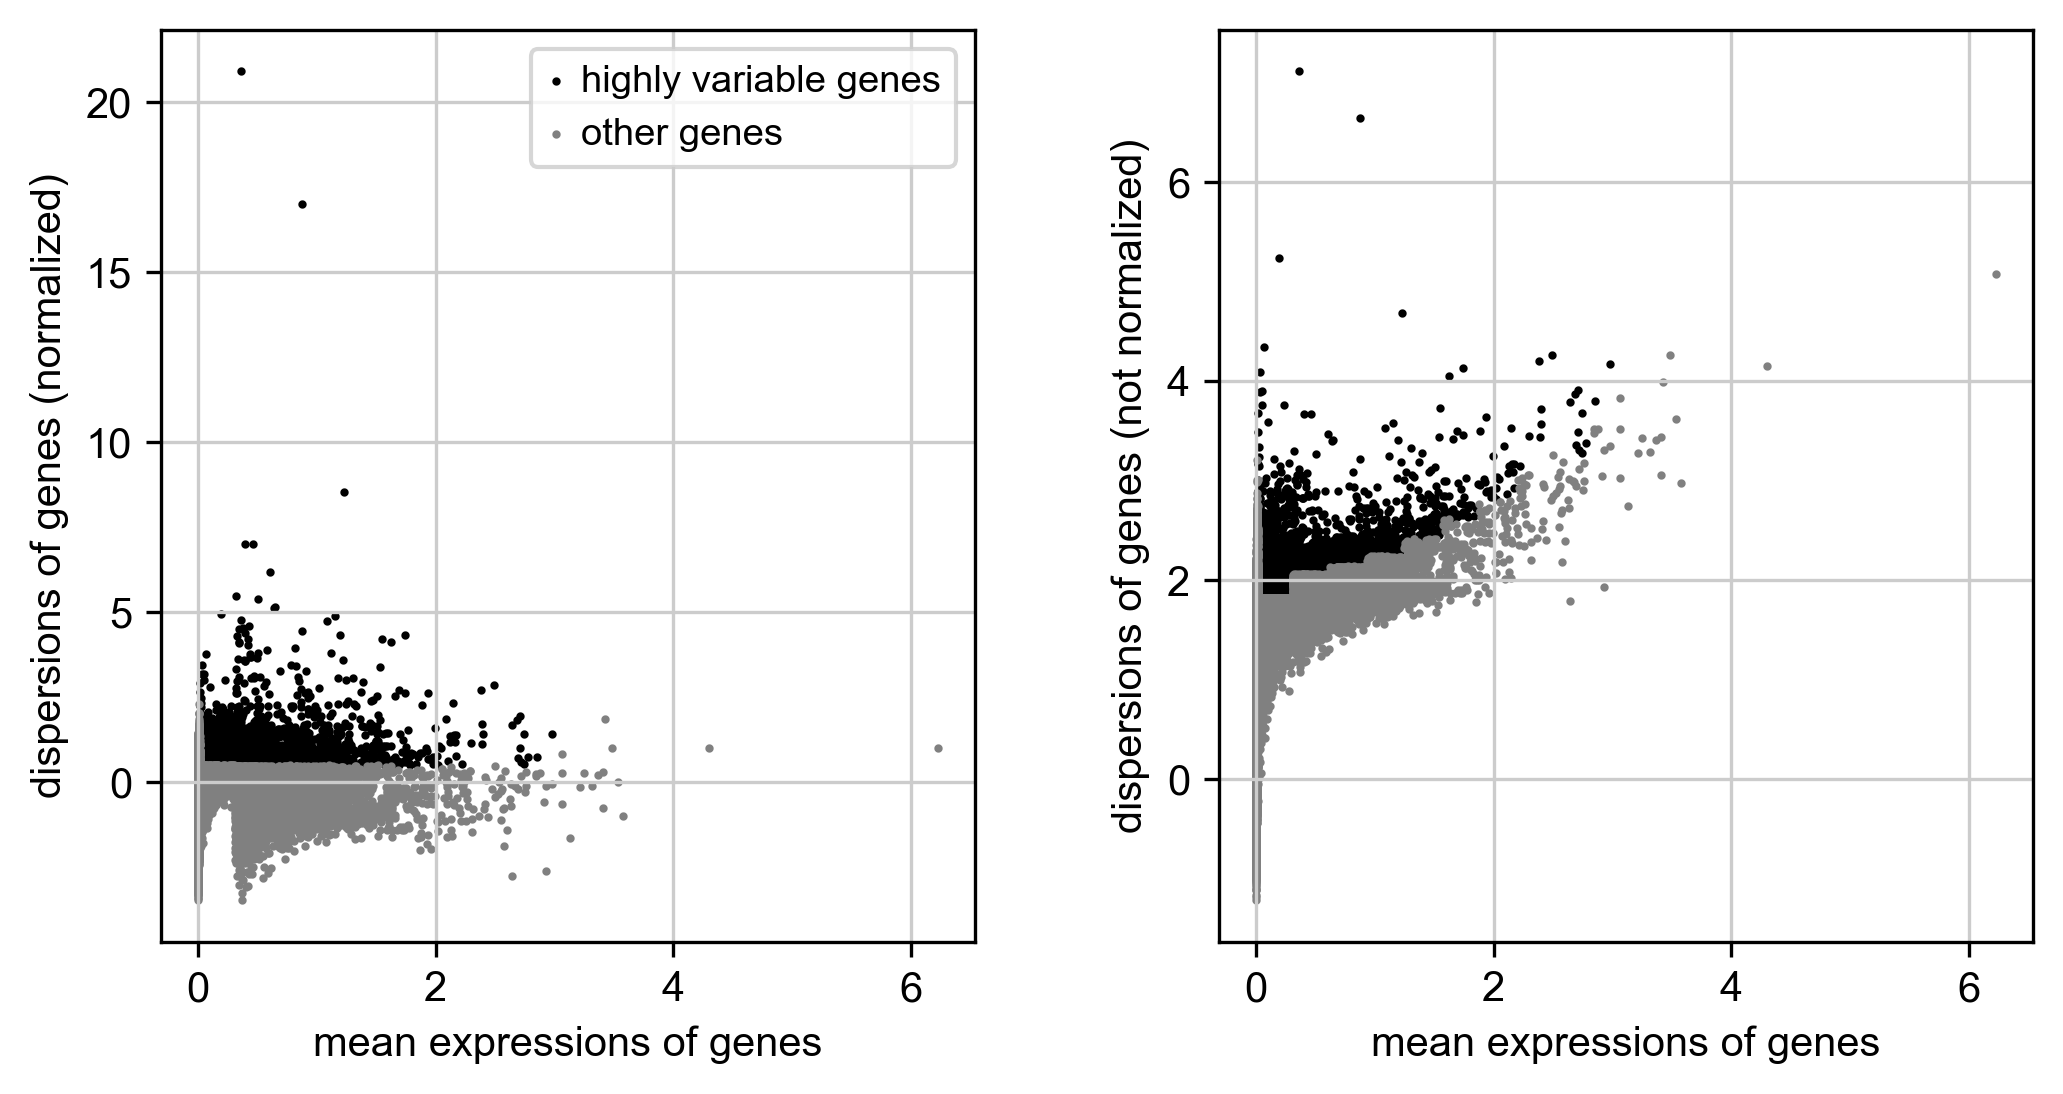

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:00)


/opt/anaconda3/envs/scenic_env_py310/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:710: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [26]:
# save a copy of the raw data
adata.raw = adata

# Total-count normalize (library-size correct) to 10,000 reads/cell
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# log transform the data.
sc.pp.log1p(adata)

# identify highly variable genes.
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

# keep only highly variable genes:
adata = adata[:, adata.var['highly_variable']]

# regress out total counts per cell and the percentage of mitochondrial genes expressed
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'] ) #, n_jobs=args.threads)

# scale each gene to unit variance, clip values exceeding SD 10.
sc.pp.scale(adata, max_value=10)

# update the anndata file:
adata.write( f_anndata_path )

computing PCA
    with n_comps=50
    finished (0:00:03)


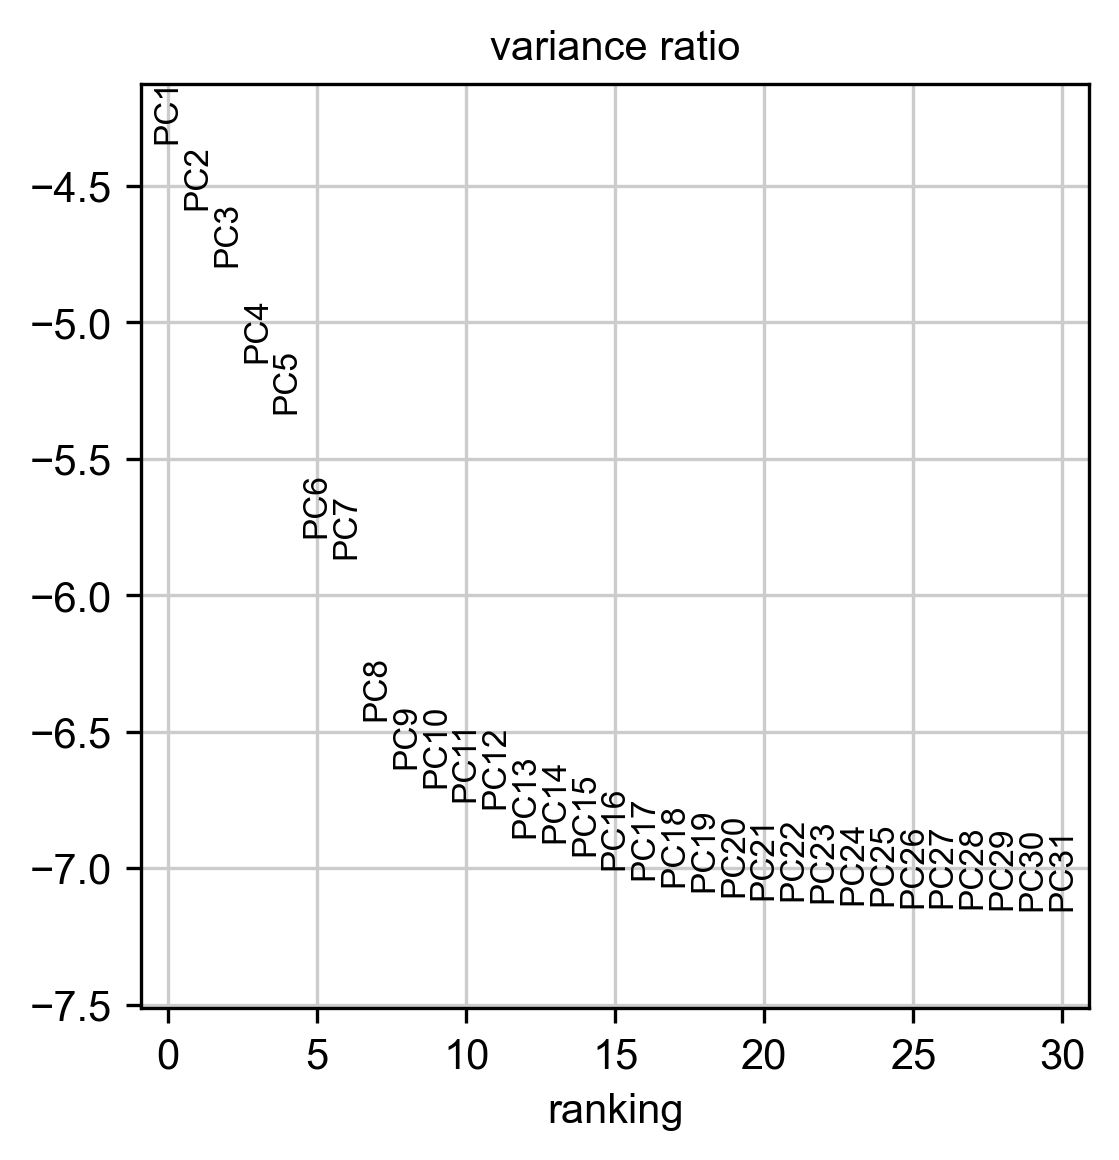

In [27]:
# adata = sc.read_h5ad( f_anndata_path )
# principal component analysis
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)
adata.write( f_anndata_path )

In [28]:
# neighborhood graph of cells (determine optimal number of PCs here)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
# compute UMAP
sc.tl.umap(adata)
# tSNE
tsne = TSNE( n_jobs=20 )
adata.obsm['X_tsne'] = tsne.fit_transform( adata.X )
adata.write( f_anndata_path )

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:04)


running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


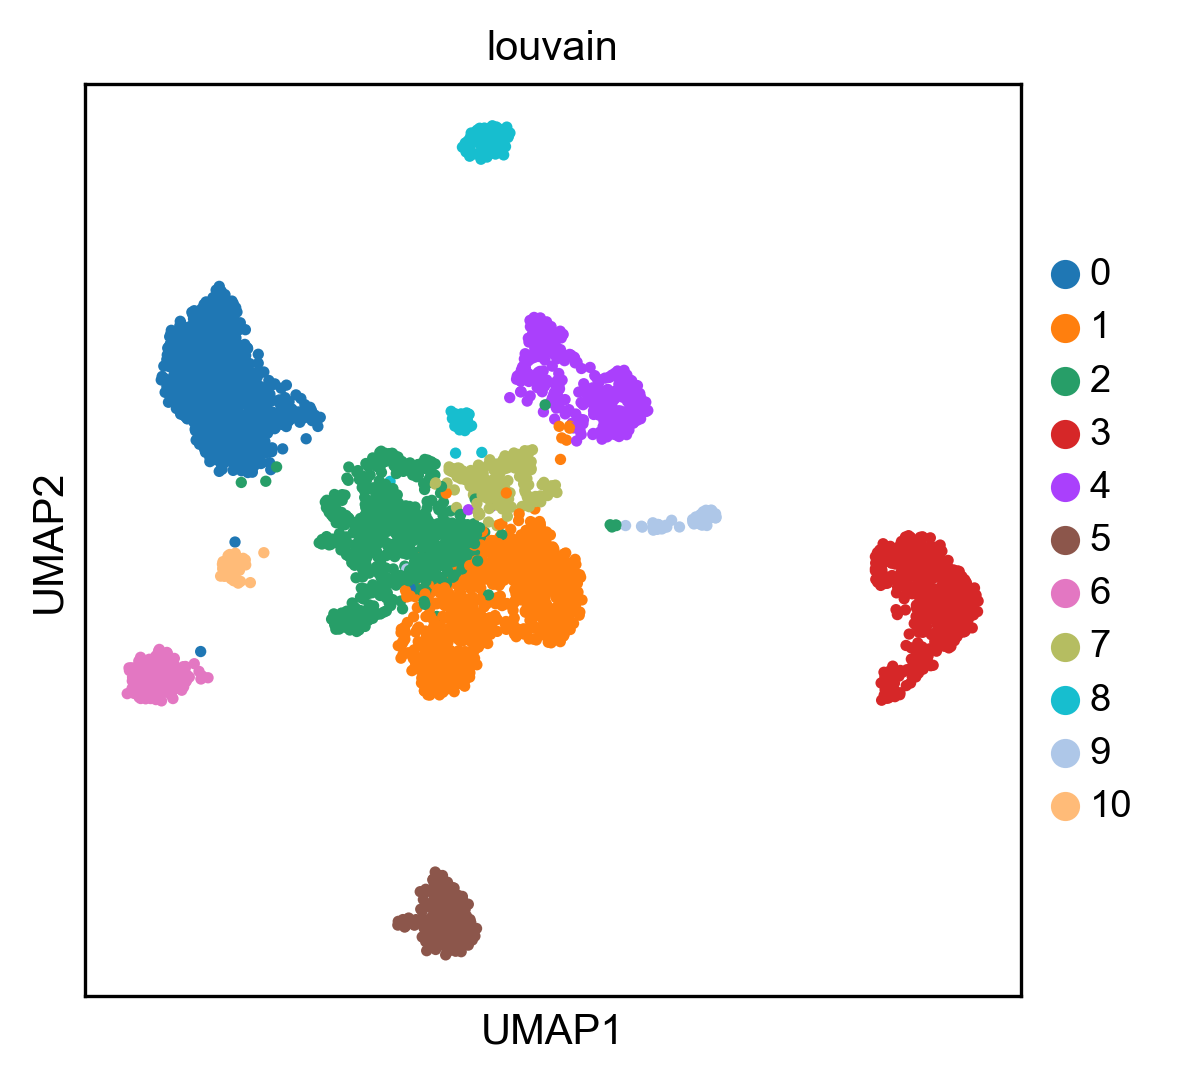

In [29]:
# cluster the neighbourhood graph
sc.tl.louvain(adata,resolution=0.4)

sc.pl.umap(adata, color=['louvain'] )

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


/opt/anaconda3/envs/scenic_env_py310/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:481: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/opt/anaconda3/envs/scenic_env_py310/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:481: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (


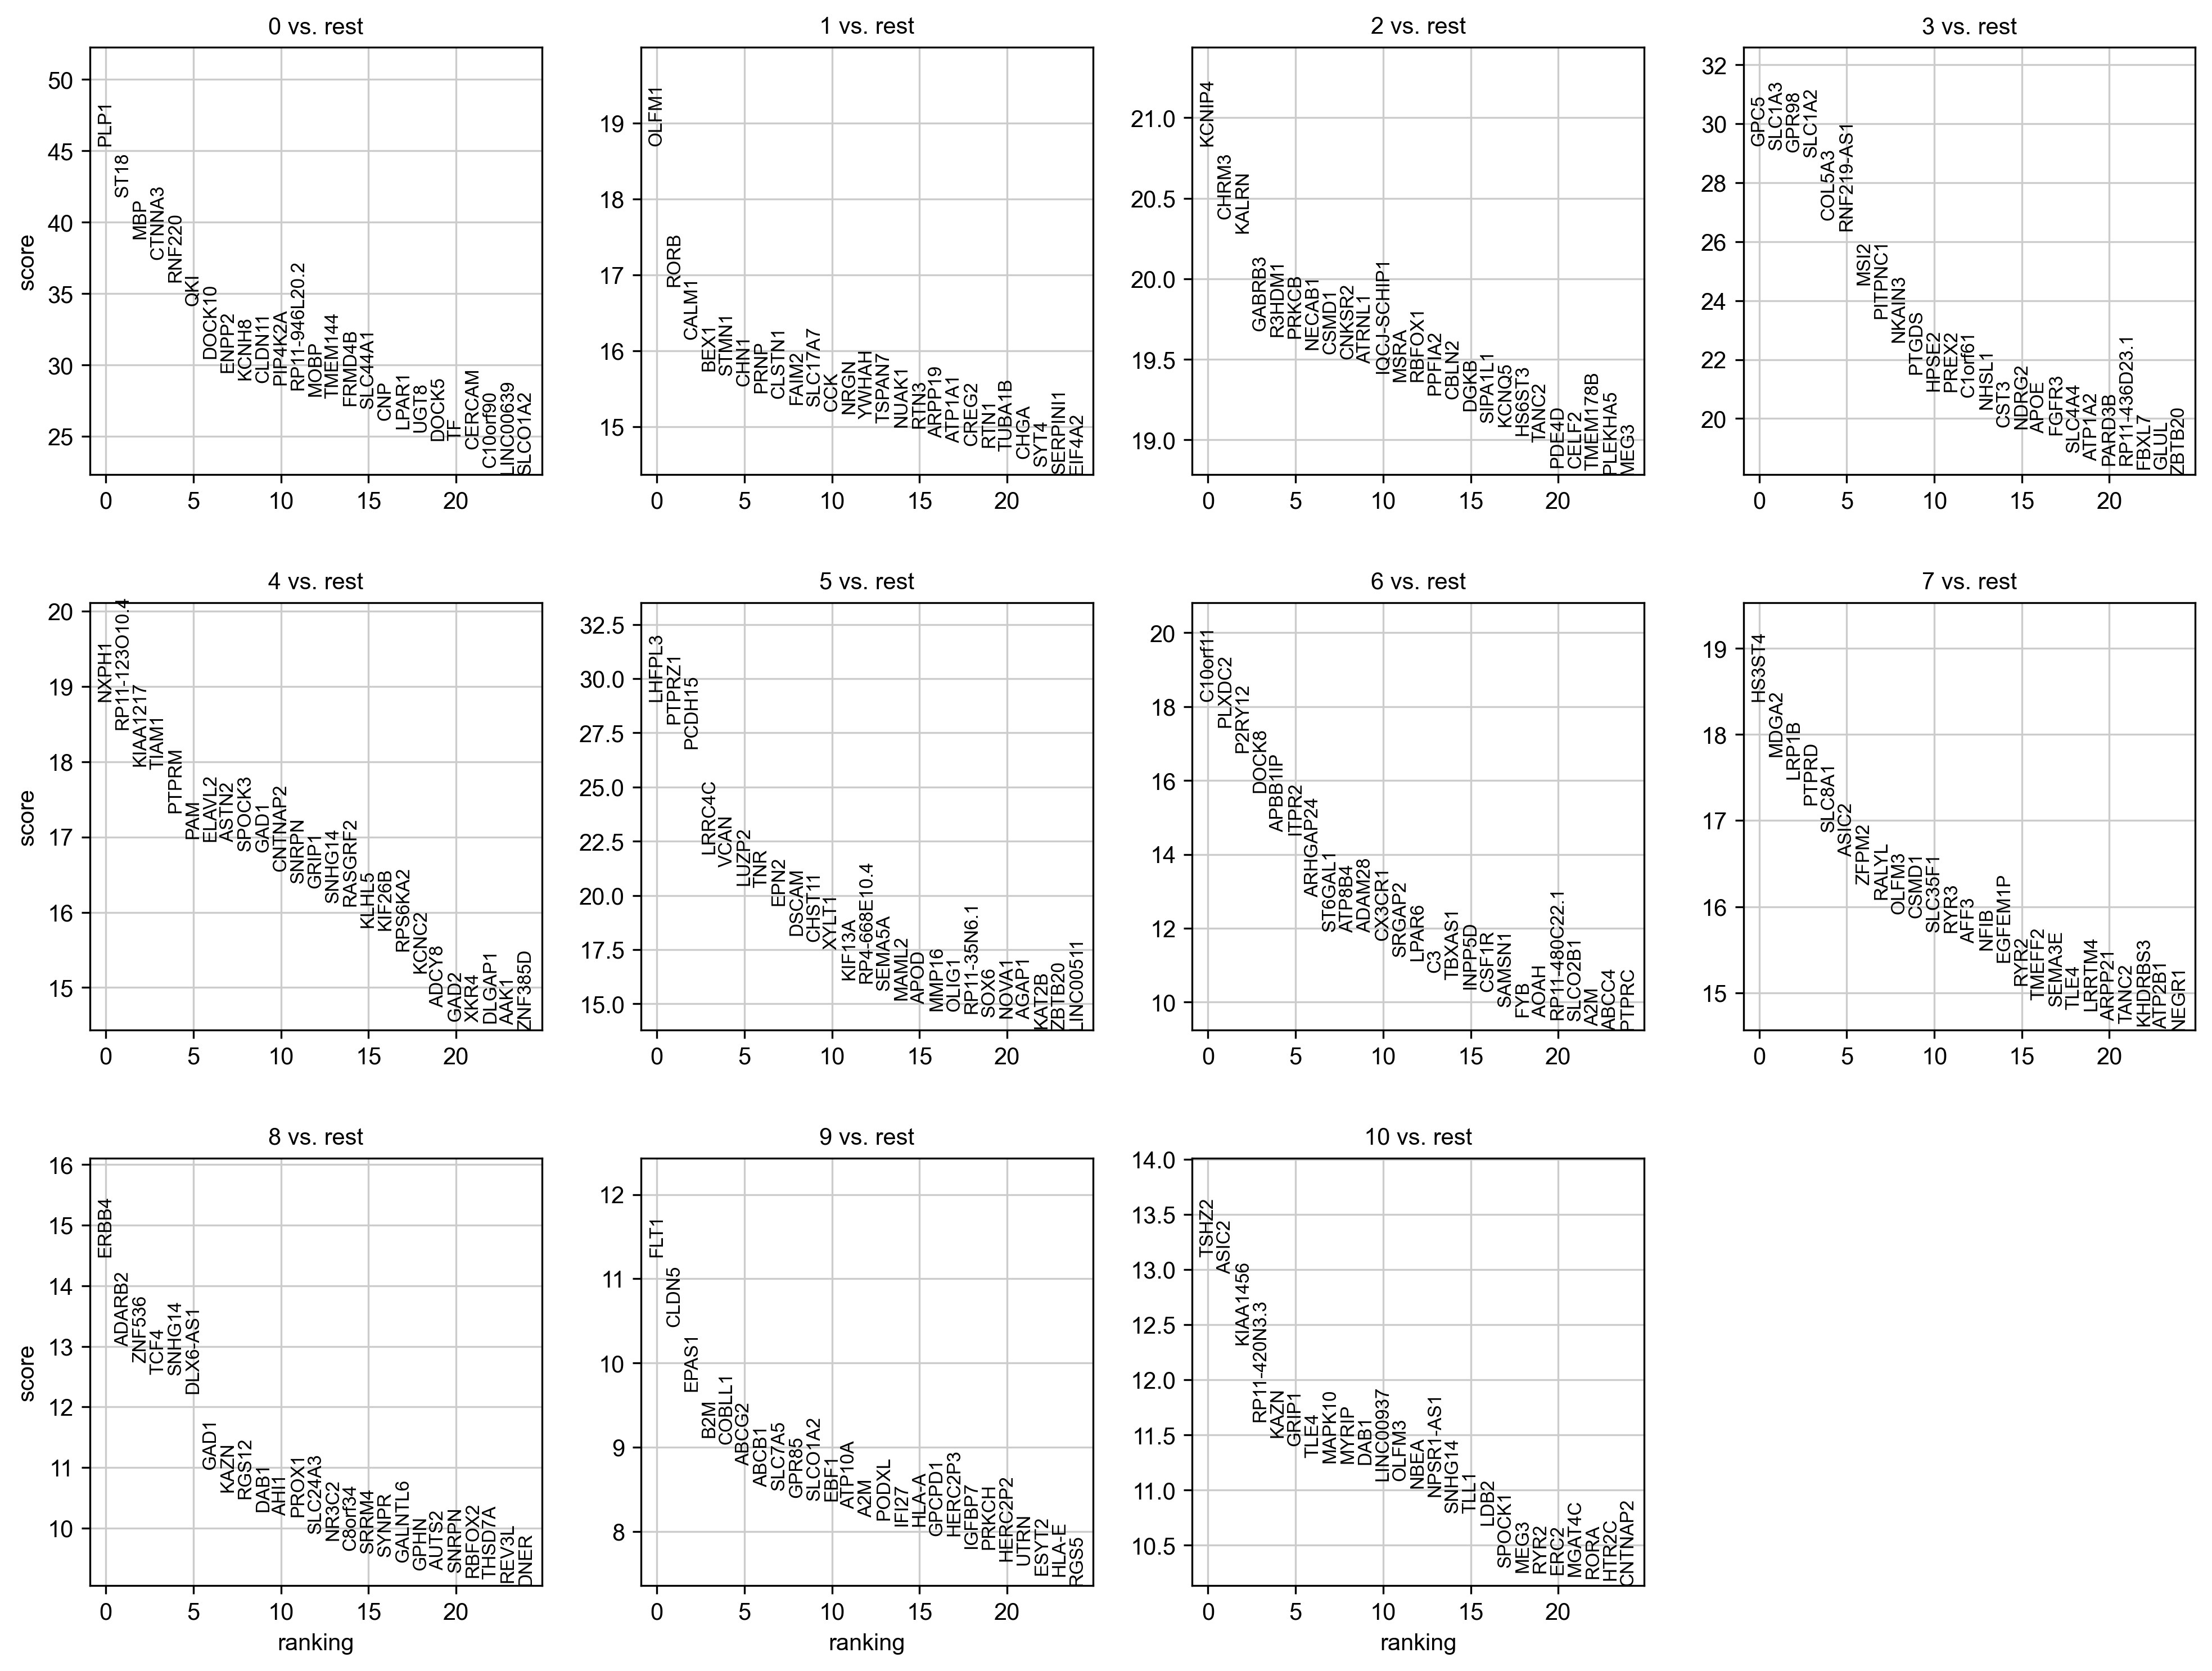

In [30]:
# find marker genes
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

# sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
# sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)
adata.write( f_anndata_path )

In [31]:
## Docker regulatory inference
#docker run -it -v /Users/jakobmaeots/Internship/Data:/data \
#aertslab/pyscenic:0.11.0 \
#pyscenic grn \
#--num_workers 2 \ 
#--output /data/-----adj.tsv \
#--method grnboost2 \
#/data/----------.loom \
#/data/allTFs_hg38.txt #worked

#docker run -it --rm \
    #-v /Users/jakobmaeots/Internship/Data:/data \
   # aertslab/pyscenic:0.12.0 \
    #pyscenic ctx \
    #/data/-------adj.tsv \
    #/data/hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather \
    #--annotations_fname /data/motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl \
    #--expression_mtx_fname /data/-----------.loom \
    #--mode "dask_multiprocessing" \
    #--output /data/-----reg.csv \
    #--num_workers 3 \
    #--mask_dropouts #worked

#docker run -it --rm \
    #-v /Users/jakobmaeots/Internship/Data:/data \
    #aertslab/pyscenic:0.12.0 \
    #pyscenic aucell \
    #/data/-------------.loom\
    #/data/----------.csv\
    #--output /data/--------_SCENIC.loom\
    #--num_workers 3 #worked

In [32]:
import json
import zlib
import base64

# collect SCENIC AUCell output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [33]:
import umap

# UMAP
runUmap = umap.UMAP(n_neighbors=10, min_dist=0.4, metric='correlation').fit_transform
dr_umap = runUmap( auc_mtx )
pd.DataFrame(dr_umap, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "scenic_umap.txt", sep='\t')
# tSNE
tsne = TSNE( n_jobs=20 )
dr_tsne = tsne.fit_transform( auc_mtx )
pd.DataFrame(dr_tsne, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "scenic_tsne.txt", sep='\t')

In [34]:
# scenic output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
#exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID)
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
regulons = lf.ra.Regulons
dr_umap = pd.read_csv( 'scenic_umap.txt', sep='\t', header=0, index_col=0 )
dr_tsne = pd.read_csv( 'scenic_tsne.txt', sep='\t', header=0, index_col=0 )
###

In [35]:
auc_mtx.columns = auc_mtx.columns.str.replace('\(','_(')
regulons.dtype.names = tuple( [ x.replace("(","_(") for x in regulons.dtype.names ] )
# regulon thresholds
rt = meta['regulonThresholds']
for i,x in enumerate(rt):
    tmp = x.get('regulon').replace("(","_(")
    x.update( {'regulon': tmp} )

In [36]:
tsneDF = pd.DataFrame(adata.obsm['X_tsne'], columns=['_X', '_Y'])

Embeddings_X = pd.DataFrame( index=lf.ca.CellID )
Embeddings_X = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[0] ,
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[0] ,
        dr_tsne['X'] ,
        dr_umap['X']
    ], sort=False, axis=1, join='outer' )
Embeddings_X.columns = ['1','2','3','4']

Embeddings_Y = pd.DataFrame( index=lf.ca.CellID )
Embeddings_Y = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[1] ,
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[1] ,
        dr_tsne['Y'] ,
        dr_umap['Y']
    ], sort=False, axis=1, join='outer' )
Embeddings_Y.columns = ['1','2','3','4']

In [37]:
### metadata
metaJson = {}

metaJson['embeddings'] = [
    {
        "id": -1,
        "name": f"Scanpy t-SNE (highly variable genes)"
    },
    {
        "id": 1,
        "name": f"Scanpy UMAP  (highly variable genes)"
    },
    {
        "id": 2,
        "name": "Scanpy PC1/PC2"
    },
    {
        "id": 3,
        "name": "SCENIC AUC t-SNE"
    },
    {
        "id": 4,
        "name": "SCENIC AUC UMAP"
    },
]

metaJson["clusterings"] = [{
            "id": 0,
            "group": "Scanpy",
            "name": "Scanpy louvain default resolution",
            "clusters": [],
        }]

metaJson["metrics"] = [
        {
            "name": "nUMI"
        }, {
            "name": "nGene"
        }, {
            "name": "Percent_mito"
        }
]

metaJson["annotations"] = [
    {
        "name": "Louvain_clusters_Scanpy",
        "values": list(set( adata.obs['louvain'].astype(str) ))
    },
    #{
    #    "name": "Genotype",
    #    "values": list(set(adata.obs['Genotype'].values))
    #},
    #{
    #    "name": "Timepoint",
    #    "values": list(set(adata.obs['Timepoint'].values))
    #},
    #{
    #    "name": "Sample",
    #    "values": list(set(adata.obs['Sample'].values))
    #}
]

# SCENIC regulon thresholds:
metaJson["regulonThresholds"] = rt

for i in range(max(set([int(x) for x in adata.obs['louvain']])) + 1):
    clustDict = {}
    clustDict['id'] = i
    clustDict['description'] = f'Unannotated Cluster {i + 1}'
    metaJson['clusterings'][0]['clusters'].append(clustDict)
    
clusterings = pd.DataFrame()
clusterings["0"] = adata.obs['louvain'].values.astype(np.int64)

In [38]:
def dfToNamedMatrix(df):
    arr_ip = [tuple(i) for i in df.values]
    dtyp = np.dtype(list(zip(df.dtypes.index, df.dtypes)))
    arr = np.array(arr_ip, dtype=dtyp)
    return arr

In [39]:
col_attrs = {
    "CellID": np.array(adata.obs.index),
    "nUMI": np.array(adata.obs['n_counts'].values),
    "nGene": np.array(adata.obs['n_genes'].values),
    "Louvain_clusters_Scanpy": np.array( adata.obs['louvain'].values ),
    #"Genotype": np.array(adata.obs['Genotype'].values),
    #"Timepoint": np.array(adata.obs['Timepoint'].values),
    #"Sample": np.array(adata.obs['Sample'].values),
    "Percent_mito": np.array(adata.obs['percent_mito'].values),
    "Embedding": dfToNamedMatrix(tsneDF),
    "Embeddings_X": dfToNamedMatrix(Embeddings_X),
    "Embeddings_Y": dfToNamedMatrix(Embeddings_Y),
    "RegulonsAUC": dfToNamedMatrix(auc_mtx),
    "Clusterings": dfToNamedMatrix(clusterings),
    "ClusterID": np.array(adata.obs['louvain'].values)
}

row_attrs = {
    "Gene": lf.ra.Gene,
    "Regulons": regulons,
}

attrs = {
    "title": "sampleTitle",
    "MetaData": json.dumps(metaJson),
    "Genome": 'hg38',
    "SCopeTreeL1": "",
    "SCopeTreeL2": "",
    "SCopeTreeL3": ""
}

# compress the metadata field:
attrs['MetaData'] = base64.b64encode(zlib.compress(json.dumps(metaJson).encode('ascii'))).decode('ascii')

In [40]:
lp.create(
    filename = f_final_loom ,
    layers=lf[:,:],
    row_attrs=row_attrs, 
    col_attrs=col_attrs, 
    file_attrs=attrs
)
lf.close() # close original pyscenic loom file

In [56]:
# Assuming adata is your AnnData object
# Create a new column with the 'cell_' prefix
adata.obs['cell_id'] = 'cell_' + adata.obs['obs_names'].astype(str)

# Select the columns to save
data_to_save = adata.obs[['cell_id', 'cluster']]

# Save as a .tsv file
tsv_file_path = '/Users/jakobmaeots/Internship/Data/Velmeshev/CTRL_cell_cluster_identifiers.tsv'
data_to_save.to_csv(tsv_file_path, sep='\t', index=False)

# Save as a .csv file
csv_file_path = '/Users/jakobmaeots/Internship/Data/Velmeshev/CTRL_cell_cluster_identifiers.csv'
data_to_save.to_csv(csv_file_path, index=False)

print(f"Data saved to {tsv_file_path} and {csv_file_path}")

Data saved to cell_cluster_identifiers.tsv and cell_cluster_identifiers.csv
